# Weather Project
Brett Keller  
Final Project  
08/12/21

The purpose of this project is to analyse weather data from WWII weather stations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import thinkstats2
import thinkplot

from statistics import mode
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

### The Data
These data describe temperature, precipitation, and other weather conditions across 161 land based weather stations from 1940 to 1945. The data was collected by the National Centres for Environmental Information and aggregated from https://www.kaggle.com/smid80/weatherww2.

###### Loading the Data

In [2]:
# weather data
weather = pd.read_csv(r'weather.csv', header = 0, 
                      names=['station_number', 'date', 'precipitation', 'peak_wind_speed', 'max_temp', 'min_temp', 'mean_temp',
                            'snowfall', 'bad_weather', 'year', 'month', 'day', 'precip_inches', 'peak_wind_direction', 
                             'wind_knots', 'max_f', 'min_f', 'mean_f', 'snow_in', 'snow_depth1', 'frozen_top', 'frozen_base', 
                             'ground_ice', 'water_ice', 'peak_wind_time', 'storms', 'snow_depth2', 'max_humidity', 
                             'min_humidity', 'river_guage', 'water_equivalent'])
weather.head(5)

,station_number,date,precipitation,peak_wind_speed,max_temp,min_temp,mean_temp,snowfall,bad_weather,year,...,frozen_base,ground_ice,water_ice,peak_wind_time,storms,snow_depth2,max_humidity,min_humidity,river_guage,water_equivalent
0,10001,7/1/1942,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,7/2/1942,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,7/3/1942,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,7/4/1942,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,7/5/1942,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# station data
stations = pd.read_csv(r'stations.csv', header = 0, 
                       names=['station_number', 'station_name', 'country_id', 'lat_str', 'lon_str', 'elevation', 'latitude', 
                              'longitude'])
stations.sample(5)

,station_number,station_name,country_id,lat_str,lon_str,elevation,latitude,longitude
34,32301,LUXOR,EG,2542N,03242E,86,25.700000,32.666667
121,31001,KANO,NI,1203N,00832E,475,12.050000,8.500000
87,33014,DECIMOMANNO,IY,3918N,00910E,7,39.300000,9.250000
49,16405,NARSARSSUAK,GL,6111N,04525W,11,61.183333,-45.366667
40,81702,NANDI/AAF,FJ,1745S,17725E,10,-17.750000,177.366667


###### Cleaning Data

In [4]:
# changes items in 'dates' column to datetime objects
weather.date = pd.to_datetime(weather.date, format = '%m/%d/%Y')

In [5]:
# changes 'T' to 0.00 in precipitation column
weather.loc[(weather.precipitation == 'T'), 'precipitation'] = 0.00

In [6]:
# removes rows with missing values for snowfall
weather.dropna(subset=['snowfall'], inplace=True)

In [7]:
# changes precipitation, snowfall columns to float type
weather.precipitation = weather.precipitation.astype(float)
weather.snowfall = weather.snowfall.astype(float)

In [8]:
# removes columns with insufficient, redundant, or irrelevant data
weather = weather[['station_number', 'date', 'month', 'max_temp', 'min_temp', 'mean_temp', 'precipitation', 'snowfall']]
stations = stations[['station_number', 'latitude', 'longitude', 'elevation',]]

In [9]:
# combines data frames using station number
df = pd.merge(left=weather, right=stations)

### The Variables

###### Coordinates

There are three variables that describe the location of each station: latitude, longitude, and elevation above sea level in meters.

Most of the stations are located close to the equator, though there are a handful of stations north of the 60th parallel. The project that collected this data seems to have focused on nations that did not already have their own weather stations; most of Northern America, Europe, and East Asia have just a handful of stations representing them.

Most of the stations are also located very close to sea level. None of the stations are located below sea level, but there are several that are well above it that skew the distribution to the right. The highest is a station located in Asmara, Eritrea at 7,631 feet above sea level. The mean elevation is 427 ft, the mode is 10 ft, and the standard deviation is 1,037 ft.

There were a handful of stations that did not have an elevation recorded. Googling the coordinates, I was able to find the meters above sea level for the general area. This seemed to be only a meter or two off when I compared this method with the elevations that were recorded.

It appears that all of the stations were operating for roughly the same amount of time, so none of the locations should be over or underrepresented.

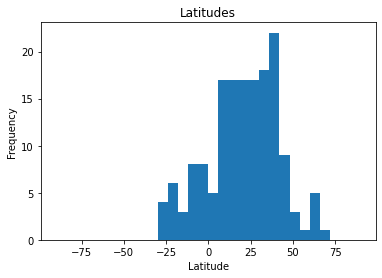

In [10]:
# histogram for latitudes
plt.hist(stations.latitude, bins = 30, range = [-90,90])
plt.title('Latitudes')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.show()

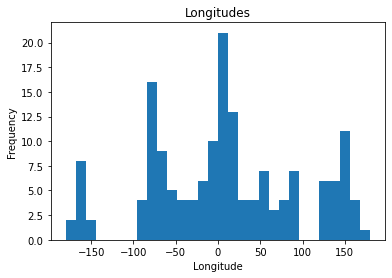

In [11]:
# histogram for longitudes
plt.hist(stations.longitude, bins = 30, range = [-180,180])
plt.title('Longitudes')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.show()

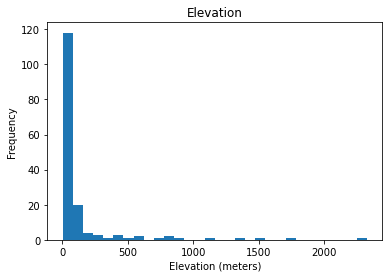

In [12]:
# histogram for elevation
plt.hist(stations.elevation, bins = 30)
plt.title('Elevation')
plt.xlabel('Elevation (meters)')
plt.ylabel('Frequency')
plt.show()

In [13]:
# mean, mode, and standard deviation
mean0 = stations.elevation.mean()
mode0 = mode(stations.elevation)
std0 = stations.elevation.std()
tallest = max(stations.elevation)

print('mean:  ' + str(round(mean0)) + ' m or ' + str(round(mean0*3.28084)) + ' ft\n' +
      'mode:  ' + str(round(mode0)) + ' m or ' + str(round(mode0*3.28084)) + ' ft\n' +
      'sd:    ' + str(round(std0)) + ' m or ' + str(round(std0*3.28084)) + ' ft\n' +
      'max:   ' + str(round(tallest)) + ' m or ' + str(round(tallest*3.28084)) + ' ft')

mean:  130 m or 427 ft
mode:  3 m or 10 ft
sd:    316 m or 1037 ft
max:   2326 m or 7631 ft


###### Temperature

There are three variables used to describe temperature in the dataset: the maximum, minimum, and mean temperature recorded for a given date. All are given in degrees Celsius.

The average temperature across stations is about 73F, with the average daily high of 81F and low of 64F. The standard deviation between weather stations is about 15 degrees (Fahrenheit scale). The absolute hottest temperature recorded by any of the stations in 5 year span was 122F, only 12 degrees off from the hottest temperature ever recorded in Death Valley. The coldest temperature in the dataset is -37F, a far cry from the world record of -129F in Antarctica.

The distributions are skewed negatively- the vast majority of weather stations are located in tropical and temperate latitudes, but there are a few stations located in Greenland. These stations' data seem to account for the skew in the distributions and the small blip in frequency around -18 C.

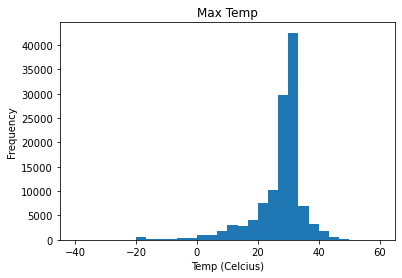

In [14]:
# histogram for max temp
plt.hist(df.max_temp, bins = 30, range = [-40,60])
plt.title('Max Temp')
plt.xlabel('Temp (Celcius)')
plt.ylabel('Frequency')
plt.show()

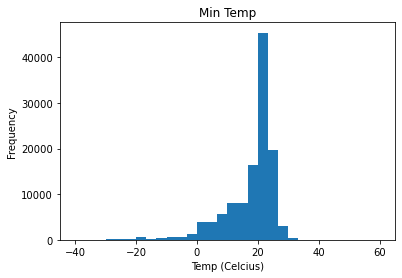

In [15]:
# histogram for min temp
plt.hist(df.min_temp, bins = 30, range = [-40,60])
plt.title('Min Temp')
plt.xlabel('Temp (Celcius)')
plt.ylabel('Frequency')
plt.show()

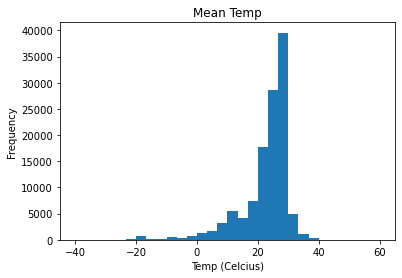

In [16]:
# histogram for mean temp
plt.hist(df.mean_temp, bins = 30, range = [-40,60])
plt.title('Mean Temp')
plt.xlabel('Temp (Celcius)')
plt.ylabel('Frequency')
plt.show()

In [17]:
# mean, mode, and standard deviation
mean1 = df.max_temp.mean()
mode1 = mode(df.max_temp)
std1 = df.max_temp.std()
mean2 = df.min_temp.mean()
mode2 = mode(df.min_temp)
std2 = df.min_temp.std()
mean3 = df.mean_temp.mean()
mode3 = mode(df.mean_temp)
std3 = df.mean_temp.std()
high_temp = max(df.max_temp)
low_temp = min(df.min_temp)

print('MEANS\n' +
      'max-temp:  ' + str(round(mean1, 1)) + ' C or ' + str(round(mean1*9/5 + 32, 1)) + ' F\n' +
      'min-temp:  ' + str(round(mean2, 1)) + ' C or ' + str(round(mean2*9/5 + 32, 1)) + ' F\n' +
      'mean-temp: ' + str(round(mean3, 1)) + ' C or ' + str(round(mean3*9/5 + 32, 1)) + ' F\n\n' +
      'MODES\n' +
      'max-temp:  ' + str(round(mode1, 1)) + ' C or ' + str(round(mode1*9/5 + 32, 1)) + ' F\n' +
      'min-temp:  ' + str(round(mode2, 1)) + ' C or ' + str(round(mode2*9/5 + 32, 1)) + ' F\n' +
      'mean-temp: ' + str(round(mode3, 1)) + ' C or ' + str(round(mode2*9/5 + 32, 1)) + ' F\n\n' +
      'STANDARD DEVIATONS\n' +
      'max-temp:  ' + str(round(std1, 1)) + ' C or ' + str(round(std1*1.8, 1)) + ' F\n' +
      'min-temp:  ' + str(round(std2, 1)) + ' C or ' + str(round(std2*1.8, 1)) + ' F\n' +
      'mean-temp: ' + str(round(std3, 1)) + ' C or ' + str(round(std3*1.8, 1)) + ' F\n\n'
      'EXTREMES\n' + 
      'highest temp: ' + str(round(high_temp, 1)) + ' C or ' + str(round(high_temp*9/5 + 32, 1)) + 'F\n' +
      'lowest temp: ' + str(round(low_temp, 1)) + ' C or ' + str(round(low_temp*9/5 + 32, 1)) + 'F')

MEANS
max-temp:  27.3 C or 81.1 F
min-temp:  18.0 C or 64.4 F
mean-temp: 22.6 C or 72.7 F

MODES
max-temp:  30.0 C or 86.0 F
min-temp:  22.2 C or 72.0 F
mean-temp: 26.7 C or 72.0 F

STANDARD DEVIATONS
max-temp:  8.4 C or 15.2 F
min-temp:  8.1 C or 14.6 F
mean-temp: 8.0 C or 14.5 F

EXTREMES
highest temp: 50.0 C or 122.0F
lowest temp: -38.3 C or -37.0F


###### Precipitation

The notes for the 'precipitation' column just say that the values are measured in millimeters. The 'snowfall' description says that it is snow and ice pellets measured in millimeters. Since there are plenty of instances where snowfall is measured but no 'precipitation', I can only assume that they mean rainfall- not all forms of precipitation. 

'T' was input to stand for 'trace precipitation'. For the purpose of this analysis, I converted these to a value of 0. See # see https://www.thoughtco.com/what-is-trace-of-precipitation-3444238

Most days do not rain or snow, so the mean precipitation is 0 inches. The highest recorded amount of rain in a day was around 12 inches, which is about what you would expect during a hurricane. The most recorded snowfall from the weather stations was about 3.5 inches.

A handful of stations did not collect data on snowfall, and were therefore excluded from any anaysis involving snowfall.

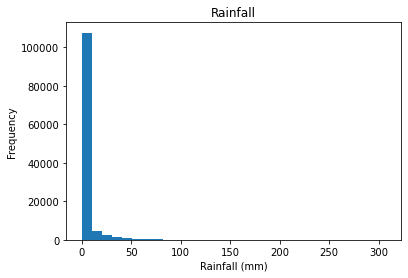

In [18]:
# histogram for rainfall
plt.hist(df.precipitation, bins = 30)
plt.title('Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()

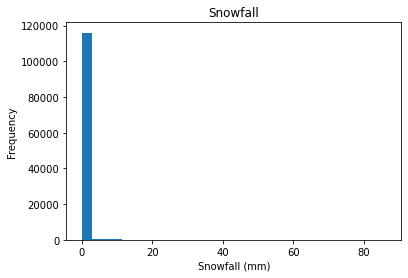

In [19]:
# histogram for snowfall
plt.hist(df.snowfall, bins = 30)
plt.title('Snowfall')
plt.xlabel('Snowfall (mm)')
plt.ylabel('Frequency')
plt.show()

In [20]:
# mean, mode, and standard deviation
mean4 = df.precipitation.mean()
mode4 = mode(df.precipitation)
std4 = df.precipitation.std()
mean5 = df.snowfall.mean()
mode5 = mode(df.snowfall)
std5 = df.snowfall.std()
high_rain = max(df.precipitation)
high_snow = max(df.snowfall)

print('MEANS\n' +
      'rainfall:  ' + str(round(mean4, 1)) + ' mm or ' + str(round(mean4/25.4, 1)) + ' in\n' +
      'snowfall: ' + str(round(mean5, 1)) + ' mm or ' + str(round(mean5/25.4, 1)) + ' in\n\n' +
      'MODES\n' +
      'rainfall:  ' + str(round(mode4, 1)) + ' mm or ' + str(round(mode4/25.4, 1)) + ' in\n' +
      'snowfall: ' + str(round(mode5, 1)) + ' mm or ' + str(round(mode5/25.4, 1)) + ' in\n\n' +
      'STANDARD DEVIATONS\n' +
      'rainfall:  ' + str(round(std4, 1)) + ' mm or ' + str(round(std4/25.4, 1)) + ' in\n' +
      'snowfall: ' + str(round(std5, 1)) + ' mm or ' + str(round(std5/25.4, 1)) + ' in\n\n'
      'EXTREMES\n' + 
      'highest rainfall: ' + str(round(high_rain, 1)) + ' mm or ' + str(round(high_rain/25.4, 1)) + 'in\n' +
      'highest snowfall: ' + str(round(high_snow, 1)) + ' mm or ' + str(round(high_snow/25.4, 1)) + 'in')

MEANS
rainfall:  3.2 mm or 0.1 in
snowfall: 0.2 mm or 0.0 in

MODES
rainfall:  0.0 mm or 0.0 in
snowfall: 0.0 mm or 0.0 in

STANDARD DEVIATONS
rainfall:  10.8 mm or 0.4 in
snowfall: 2.6 mm or 0.1 in

EXTREMES
highest rainfall: 307.3 mm or 12.1in
highest snowfall: 86.4 mm or 3.4in


### PMFs and CDFs

###### Summer vs Winter PMFs

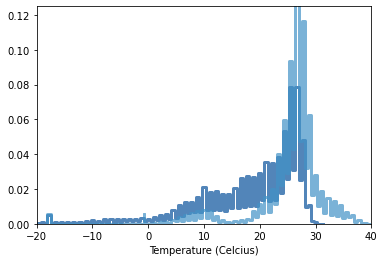

<Figure size 576x432 with 0 Axes>

In [21]:
# splits data for meteorological winter and summer in the northern hemisphere
winter = df.loc[((df['month'] == 1) | (df['month'] == 2) | (df['month'] == 12)) & (df['latitude'] > 0)]
summer = df.loc[((df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8)) & (df['latitude'] > 0)]

# creates pmfs
winter_pmf = thinkstats2.Pmf(winter.mean_temp)
summer_pmf = thinkstats2.Pmf(summer.mean_temp)

# plots pmfs
thinkplot.PrePlot(2)
thinkplot.Pmfs([winter_pmf, summer_pmf])
thinkplot.Show(xlabel = 'Temperature (Celcius)',
               axis = [-20, 40, 0, 0.125])

##### Summer vs Winter CDFs

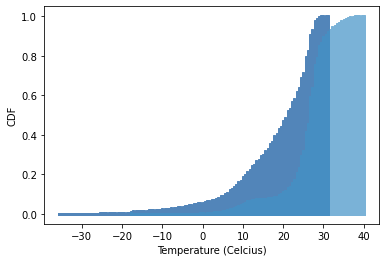

<Figure size 576x432 with 0 Axes>

In [22]:
# creates pmfs
winter_cdf = thinkstats2.Cdf(winter.mean_temp)
summer_cdf = thinkstats2.Cdf(summer.mean_temp)

# plots pmfs
thinkplot.PrePlot(2)
thinkplot.Pmfs([winter_cdf, summer_cdf])
thinkplot.Show(xlabel = 'Temperature (Celcius)',
               ylabel = 'CDF')

Summer months are more likely to have a warmer daily average temperature. There is much more variability in temperature during the winter months than during the summer months. 

### Relationships

###### Maximum and Minimum Temperature

It appears that there is a strong, positive, linear relationship between the daily maximum and daily minimum temperature. Pearson's r = 0.88

Text(0, 0.5, 'Temp (Celcius)')

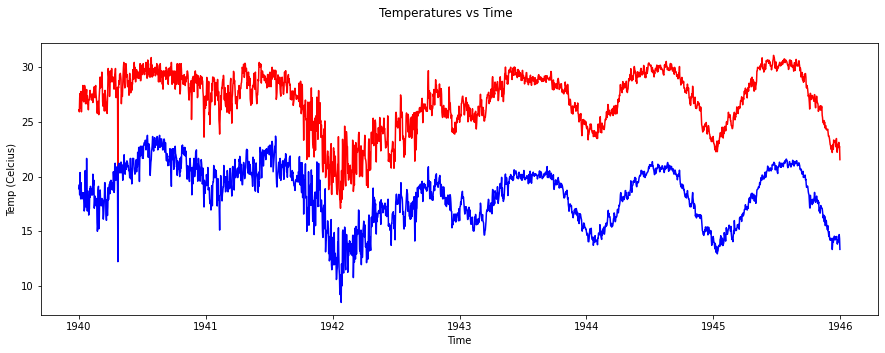

In [23]:
# shows maximum and minimum temperature over time
time_df = df.groupby(df.date).mean()
plt.figure(figsize = (15,5))
plt.plot(time_df.index, time_df.max_temp, color = 'r')
plt.plot(time_df.index, time_df.min_temp, color = 'b')
plt.suptitle('Temperatures vs Time')
plt.xlabel('Time')
plt.ylabel('Temp (Celcius)')

In [24]:
# removes outliers
smooth = df.drop(df[(df['min_temp'] < -15) & (df['max_temp'] > 15)].index)
smooth = smooth.drop(smooth[(smooth['min_temp'] > 8) & (smooth['max_temp'] < -15)].index)

Text(1.6749999999999972, 0.5, 'Min Temp (Celcius)')

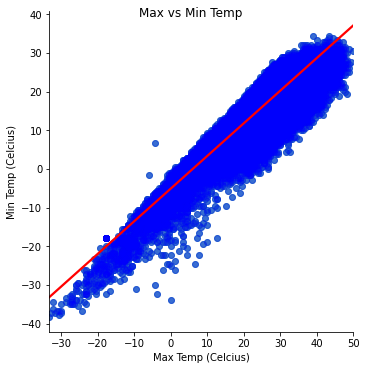

In [25]:
# plots max vs min temp with trend line
sns.lmplot(x = 'max_temp', y = 'min_temp', data = smooth, line_kws = {'color': 'red'})
plt.scatter(smooth.max_temp, smooth.min_temp, alpha = 0.25, color = 'blue')
plt.suptitle('Max vs Min Temp')
plt.xlabel('Max Temp (Celcius)')
plt.ylabel('Min Temp (Celcius)')

In [26]:
# covariance
np.cov(smooth.max_temp, smooth.min_temp)

array([[70.64025656, 59.59191169],
       [59.59191169, 65.6231118 ]])

In [27]:
# pearson correlation
np.corrcoef(smooth.max_temp, smooth.min_temp)

array([[1.        , 0.87525132],
       [0.87525132, 1.        ]])

###### Temperature and Snowfall

There is a weak, negative correlation between mean temperature and snowfall- i.e., there is generally more snow for colder temperatures. However, it looks as though the data may better be described with a non-linear model; there seems to be a sweet spot that produces the most amount of snow.

Text(10.049999999999997, 0.5, 'Snowfall (mm)')

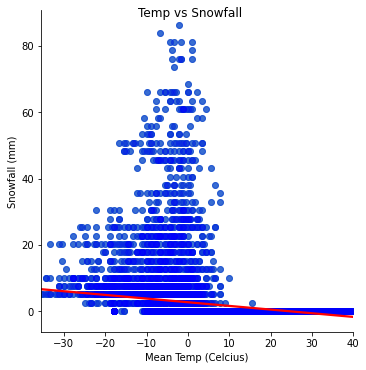

In [28]:
# plots temp vs snowfall with trend line
sns.lmplot(x = 'mean_temp', y = 'snowfall', data = df, line_kws = {'color': 'red'})
plt.scatter(df.mean_temp, df.snowfall, alpha = 0.25, color = 'blue')
plt.suptitle('Temp vs Snowfall')
plt.xlabel('Mean Temp (Celcius)')
plt.ylabel('Snowfall (mm)')

In [29]:
# covariance
np.cov(df.mean_temp, df.snowfall)

array([[64.60677702, -7.14086512],
       [-7.14086512,  6.89902803]])

In [30]:
# pearson correlation
np.corrcoef(df.mean_temp, df.snowfall)

array([[ 1.        , -0.33823445],
       [-0.33823445,  1.        ]])

### Hypothesis Testing

###### April Showers?

I would like to test the hypothesis that the average precipitation is greater in April compared to other months of the year. 
Looking at the means for each month, September had the highest average rainfall with 4.1 mm. Even looking at the number of days it rains per month, August and September are the rainiest months with over a third of the month having some precipitation.

A T-test shows that the rainfall is greater in September than April, with a p-vale < 0.001. We can reject the hypothesis that there is no difference, and in fact the difference is opposite of what folk wisdom tells us. 

In [31]:
# looks at mean precipiation for each month
month_df = df.groupby(df.month).mean()
month_df.precipitation

month
1     2.106193
2     2.145671
3     2.249660
4     2.575987
5     3.637992
6     3.828161
7     3.868092
8     4.058942
9     4.113810
10    4.032390
11    3.006514
12    2.803612
Name: precipitation, dtype: float64

In [32]:
# looks at number of days with rain
count = 1
while count < 13:
    days = np.count_nonzero(df.loc[df['month'] == count].precipitation, axis=0)
    days = round(days/len(df.loc[df['month'] == count])*100)
    print(str(count) +', ' + str(days) + '%')
    count += 1

1, 26%
2, 26%
3, 26%
4, 28%
5, 32%
6, 35%
7, 35%
8, 38%
9, 38%
10, 35%
11, 31%
12, 31%


In [33]:
# compares april with september
april = df.loc[df['month'] == 4].precipitation.values
sept = df.loc[df['month'] == 9].precipitation.values
scipy.stats.ttest_ind(april, sept)

Ttest_indResult(statistic=-9.959690723696173, pvalue=2.6016328795995256e-23)

### Regression Analysis

###### Predicting Temperature
The goal is to create a multiple regression model that predicts the mean temperature given location and date information.

In [34]:
# creates linear model to predict mean temperature
regr = linear_model.LinearRegression()
xtest = df[['latitude', 'longitude', 'elevation', 'month']]
ytest = df['mean_temp']
regr.fit(xtest, ytest)
ypredict = regr.predict(xtest)

In [35]:
# coefficients
regr.coef_

array([-0.22408665, -0.00712177, -0.00312277,  0.11955327])

In [36]:
# mean squared error
sklearn.metrics.mean_squared_error(ytest, ypredict)

44.17547272375172

In [37]:
# coefficient of determination
sklearn.metrics.r2_score(ytest, ypredict)

0.31623508142411383

### Conclusion
###### Results: Relationships
Summer months are more likely to have a warmer daily average temperature. There is much more variability in temperature during the winter months than during the summer months.  
It appears that there is a strong, positive, linear relationship between the daily maximum and daily minimum temperature. Pearson's r = 0.88.  
There is a weak, negative correlation between mean temperature and snowfall; there is generally more snow for colder temperatures. However, it looks as though the data may better be described with a non-linear model; there seems to be a sweet spot in temperature that produces the most amount of snow.  
A model was also constructed in an attempt to predict the average temperature of a given location and time of the year. Only 32% of the variation in mean temperature could be predicted from this information.  
###### Results: April Showers
The idea that April is considered a particularly rainy month has become cliche, repeated in aphorisms and platitudes. I wanted to put this to the test.  
Looking at the mean precipitation for each month, it was actually September that had the highest average rainfall- 4.1 mm. Even looking at the number of days it rains per month, August and September were tied for the rainiest months. Over a third of the days of those months have at least some rain.  
A T-test confirms that the rainfall is greater in September than April, with a p-value < 0.001. We can reject the hypothesis that there is no difference, and in fact the difference is opposite of what folk wisdom tells us.   
###### Limitations  
Only a handful of the different variables measured among the stations were collected by all stations. Wind speed, thunderstorms, and other interesting measures were just too sparsely available to provide any useful insight. Future research could not only examine other variables, but look to expand the range of weather stations worldwide over a longer breadth of time.  
Certain decisions had to be made to analyze the data. Trace amounts of rainfall were counted as no rainfall, a few stations missing elevation data that was supplemented by the average elevation of their location’s city, and some assumptions were made regarding precipitation as excluding snowfall.  
More advanced analysis could be used to analyze the data. Time-series analysis could be used to forecast the weather, non-linear relationships could be examined, similar locations could be examined through cluster analysis, and the data could be divided to better train and test the regression model. 